# Dia 5

## Objetivo de hoje:

    - Aplicar Stratified k-fold em Ensemble usando elastic net, xgboost regressor, xgboost classifier, svm, lasso e ridge.
  
    - Aplicar cross validation e ver se bate com a saída online

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Random params
np.random.seed(0)
cv = 0
random_state = 339

# Plot params
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

# Data
test = pd.read_csv('../test.csv', index_col='id')
dT = pd.read_csv('../train.csv', index_col='id')
# cols = pd.read_csv('selection_50_df.csv')
# cols = cols.loc[0:49,'Feature']
# y= dT['claim']
# dT = dT.loc[:,cols.values]
# dT['claim']=y
# test = test.loc[:,cols.values]
dT.head()


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


# Usar scaled ou normal?

In [2]:
scaler = MinMaxScaler()
scaler.fit(dT)
scaled = pd.DataFrame(scaler.transform(dT))
scaled.index = dT.index
scaled.columns = dT.columns
scaled.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.457457,0.043413,0.191647,0.070959,0.527183,0.105864,0.063687,0.102258,0.134102,0.236467,...,0.871211,0.343019,0.120557,0.261928,0.142026,0.310088,0.029364,0.040935,0.403801,1.0
1,0.443849,0.592256,0.433849,0.255789,0.830794,0.498215,0.344463,0.077000,0.434246,0.324546,...,0.456876,0.907318,0.114198,0.413351,0.136327,0.347585,0.049469,0.167787,0.150209,0.0
2,0.580343,0.022422,0.210943,0.252679,0.830402,0.540336,0.446403,0.200918,0.100675,0.376975,...,0.931311,0.216179,0.113851,0.467008,0.209030,0.276260,0.027749,0.313531,0.192805,1.0
3,0.534915,0.048887,0.208346,0.076533,0.937195,0.845347,0.059686,0.148869,0.106339,0.235366,...,0.660647,0.417911,0.116023,0.137909,0.142970,0.278298,0.026798,0.390996,0.230099,1.0
4,0.470978,0.970095,0.190185,0.271060,0.626428,0.516054,0.489029,0.048970,0.264354,0.236982,...,0.858063,0.292096,0.117449,0.351838,0.141167,0.588661,0.026758,NaN,0.131866,1.0


In [3]:
scaler2 = MinMaxScaler()
scaler2.fit(test)
scaledTest = pd.DataFrame(scaler2.transform(test))
scaledTest.index = test.index
scaledTest.columns = test.columns
scaledTest.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
id,,,,,,,,,,,,,,,,,,,,,
957919,0.563585,0.939084,0.217774,0.074639,0.579478,0.575329,0.140164,0.016310,0.107086,0.295473,...,0.177765,0.777286,0.418721,0.100999,0.211477,0.270329,0.300143,0.023960,0.178735,0.222864
957920,0.499638,0.728356,0.227271,0.582031,0.603421,0.484695,0.193863,0.300944,0.157569,0.247487,...,0.744595,0.970826,0.304576,0.094774,0.518071,0.284440,0.255833,0.155651,0.518218,0.160403
957921,0.482927,0.861450,0.206435,0.091210,0.538685,0.550829,0.510798,0.178313,0.140727,0.240202,...,0.747226,0.677563,0.435173,0.091209,0.312810,0.197571,0.260029,0.023881,0.459830,0.111317
957922,0.366016,0.770067,0.211709,0.675854,0.664407,0.530431,0.106990,0.182728,0.103933,0.238765,...,0.788282,0.963463,0.292115,0.099165,0.376163,0.179509,0.254093,0.668163,0.484018,0.176796
957923,0.411837,0.022528,0.406075,0.308549,0.812473,0.460460,0.576088,0.235698,0.106935,0.293462,...,0.255372,0.810797,0.806983,0.102351,0.290261,0.218465,0.356222,0.671932,0.195849,0.179831


# Definindo funções para ensemble

In [4]:
X = scaled.copy()
y = X.pop('claim')
print(y.head())

scaledTest = scaledTest.fillna(scaledTest.mean())
X= X.fillna(X.mean())
X.head()

id
0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: claim, dtype: float64


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
id,,,,,,,,,,,,,,,,,,,,,
0,0.457457,0.043413,0.191647,0.070959,0.527183,0.105864,0.063687,0.102258,0.134102,0.236467,...,0.131467,0.871211,0.343019,0.120557,0.261928,0.142026,0.310088,0.029364,0.040935,0.403801
1,0.443849,0.592256,0.433849,0.255789,0.830794,0.498215,0.344463,0.077000,0.434246,0.324546,...,0.874035,0.456876,0.907318,0.114198,0.413351,0.136327,0.347585,0.049469,0.167787,0.150209
2,0.580343,0.022422,0.210943,0.252679,0.830402,0.540336,0.446403,0.200918,0.100675,0.376975,...,0.208734,0.931311,0.216179,0.113851,0.467008,0.209030,0.276260,0.027749,0.313531,0.192805
3,0.534915,0.048887,0.208346,0.076533,0.937195,0.845347,0.059686,0.148869,0.106339,0.235366,...,0.026189,0.660647,0.417911,0.116023,0.137909,0.142970,0.278298,0.026798,0.390996,0.230099
4,0.470978,0.970095,0.190185,0.271060,0.626428,0.516054,0.489029,0.048970,0.264354,0.236982,...,0.831717,0.858063,0.292096,0.117449,0.351838,0.141167,0.588661,0.026758,0.322451,0.131866


In [5]:
input_shape= [X.shape[1]]
print()

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

input_shape= [X.shape[1]]

model = keras.Sequential([
    # layers.Embedding(output_dim= 64, input_length=input_shape[0]),
    layers.Dense(
        118,
        input_shape=input_shape, 
        activation='sigmoid',
        kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer = regularizers.l2(1e-4),
        activity_regularizer = regularizers.l2(1e-5)
    ),
    layers.Dense(
        118,
        input_shape=input_shape, 
        activation='sigmoid',
        kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer = regularizers.l2(1e-4),
        activity_regularizer = regularizers.l2(1e-5)
    ),
    layers.Dense(
        118,
        input_shape=input_shape, 
        activation='sigmoid',
        kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer = regularizers.l2(1e-4),
        activity_regularizer = regularizers.l2(1e-5)
    ),
    layers.Dense(1, activation='sigmoid')
])

# model = keras.Sequential([
#     layers.Dense(50,input_shape=input_shape, activation='sigmoid'),
#     layers.Dense(1, activation='sigmoid')
# ])

# model = keras.Sequential([
#     layers.Dense(118,input_shape=input_shape, activation='sigmoid'),
#     layers.Dense(1, activation='sigmoid')
# ])


model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics = ['AUC']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 118)               14042     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 119       
Total params: 14,161
Trainable params: 14,161
Non-trainable params: 0
_________________________________________________________________


In [7]:
skf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)
skf.get_n_splits(X, y)

final_predictions = []
history = []
for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X=X,y=y)):
    X_train = X.loc[train_indicies]
    X_valid = X.loc[valid_indicies]
    X_test = test.copy()
    
    y_train = y.loc[train_indicies]
    y_valid = y.loc[valid_indicies]

    # elNET = ElasticNet(
    #     alpha=5.0, 
    #     l1_ratio=0.2,
    #     precompute=True, 
    #     max_iter=20000, 
    #     copy_X=True, 
    #     tol=0.00001, 
    #     warm_start=True, 
    #     random_state=random_state, 
    #     selection='random')

    # elNET.fit(X_train, y_train)

#     catBOOST = CatBoostClassifier(iterations=10, 
#                            task_type="GPU",
#                            border_count=254,
#                            devices='0:1',
#                            eval_metric='AUC')
    model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        epochs=10,
        batch_size = 1000,
        verbose=1)

    preds_valid = model.predict(X_valid)
    preds_test = model.predict(X_test)
    final_predictions.append(preds_test)
    history.append([fold, roc_auc_score(y_valid, preds_valid)])


Epoch 1/10
863/863 [==============================] - 4s 4ms/step - loss: 0.8349 - auc: 0.5001 - val_loss: 0.6956 - val_auc: 0.5000
Epoch 2/10
863/863 [==============================] - 3s 3ms/step - loss: 0.6955 - auc: 0.5000 - val_loss: 0.6960 - val_auc: 0.5000
Epoch 3/10
863/863 [==============================] - 3s 4ms/step - loss: 0.6956 - auc: 0.5008 - val_loss: 0.6966 - val_auc: 0.5021
Epoch 4/10
863/863 [==============================] - 4s 4ms/step - loss: 0.6957 - auc: 0.5005 - val_loss: 0.6960 - val_auc: 0.5000
Epoch 5/10
863/863 [==============================] - 3s 4ms/step - loss: 0.6956 - auc: 0.4996 - val_loss: 0.6953 - val_auc: 0.5000
Epoch 6/10
863/863 [==============================] - 3s 4ms/step - loss: 0.6956 - auc: 0.4999 - val_loss: 0.6955 - val_auc: 0.5000
Epoch 7/10
863/863 [==============================] - 4s 4ms/step - loss: 0.6957 - auc: 0.4999 - val_loss: 0.6959 - val_auc: 0.5000
Epoch 8/10
863/863 [==============================] - 3s 3ms/step - loss: 0.

In [ ]:
# from sklearn.linear_model import ElasticNetCV

# regr = ElasticNetCV(cv=15, random_state=random_state)
# regr.fit(X, y)
print(history)
# print(max(history,1))
# print(len(history))
# print(history[:][:][0])
maior =0.0
for ii in range(len(history)):
    print(history[ii][1])
    if history[ii][1]>maior:
        maior = history[ii][1]
        print(maior)
        max_index = ii
# max_index = history.index(.max)
print(max_index)
print(history[max_index][1])


[]


NameError: name 'max_index' is not defined

In [ ]:
# scores = cross_val_score(regr, X, y, scoring='roc_auc', cv=15, n_jobs=-1)
# print(scores)

In [ ]:
# preds_test = regr.predict(X_test)
# final_predictions.append(preds_test)


In [ ]:
# print(final_predictions)
# print(preds_test)

In [ ]:
sub = final_predictions[:][max_index]

id       1.204656e+08
claim    3.585656e+01
dtype: float64


<AxesSubplot:>

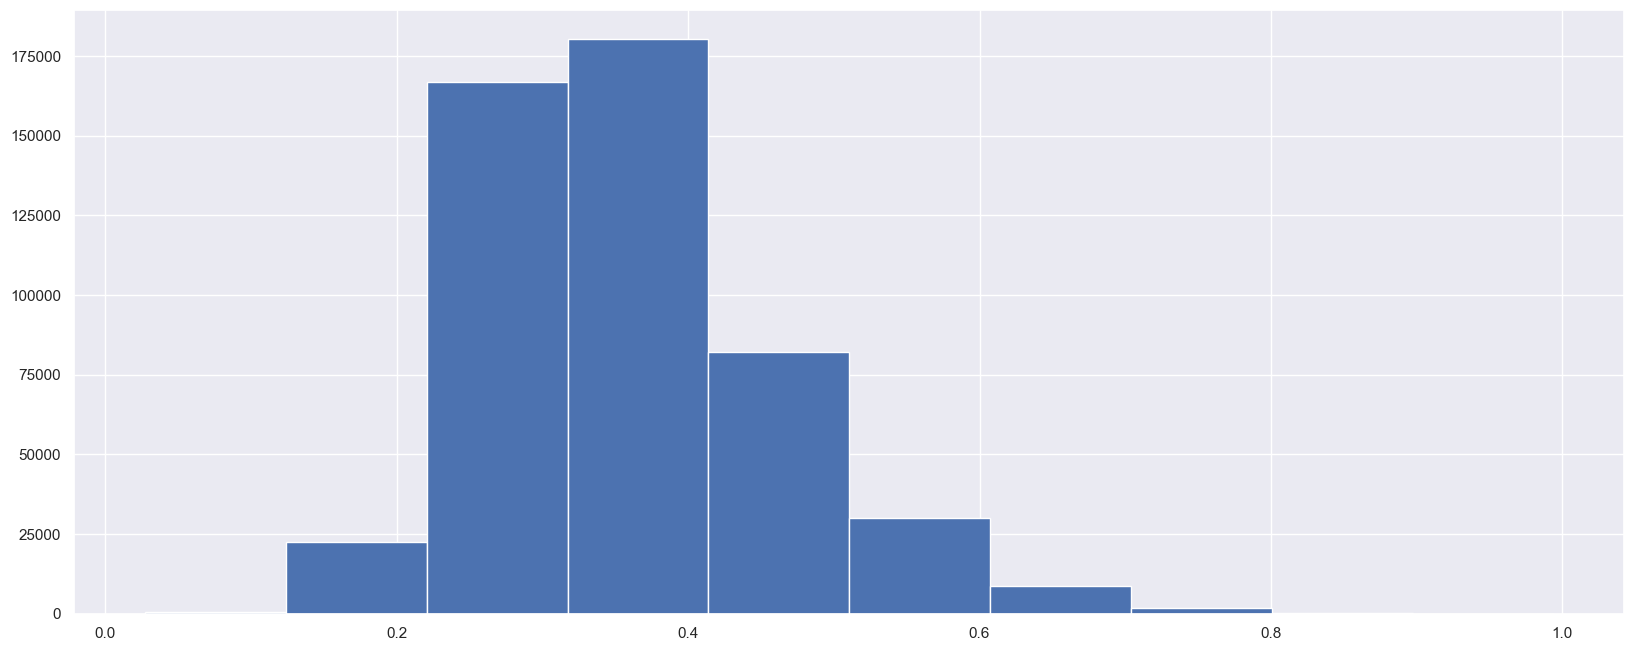

In [ ]:
mysub = pd.DataFrame(test['id'])
mysub['claim'] = sub
mysub['claim'] = mysub['claim'].fillna(0)
print(mysub.mean()*100)
mysub['claim'].hist()

In [ ]:
mysub.head()

,id,claim
0,957919,0.302694
1,957920,0.276658
2,957921,0.350163
3,957922,0.363874
4,957923,0.322233


In [ ]:
var = 'softmax_shallow'
mysub.to_csv(var+'_submisssion.csv',index=False)

NameError: name 'mysub' is not defined

# Treinando ensemble

# Vendo resultados:

# Criando submissão: